# LIVE DATA READING AND PREDICTION

To predict on real time it is needed to have online measurement.

Ayuntamiento de Madrid in its web (https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=41e01e007c9db410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
about AirQuality, provide measurements for all Air stations updated in real time, being the data updated every hour. This data update will happen between the minutes 20 and 30 of every hour.


**Disclaimer of live data: This data is live data automatically measured by the AirStations without any quality check, so data is pending to be reviewed and validated.**

In [75]:
#Libraries
#########

import requests
import numpy as np
import pandas as pd
import io
import time
import datetime
from datetime import timedelta
from datetime import datetime
import pickle

#Libraries for data visualization
#################################
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sbn
%matplotlib inline
import altair as alt
import folium


#Libraries/functions for ARIMA modelling
#######################################
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
import statsmodels.api as sm

# Reading and preparing data

In [76]:
#Loading the model previously designed in notebook 4.Modelling SARIMA poc16
###########################################################################

pickled_model = pickle.load(open('../models/poc_16_SARIMAmodel_301_311_12.pkl', 'rb'))

In [77]:

#Reading Air quality live data from online service from Ayuntamiento de Madrid web
##################################################################################

url = 'https://www.mambiente.madrid.es/opendata/horario.csv'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
response = requests.get(url, headers=headers)
df_airlive = pd.read_csv(io.StringIO(response.text), sep=';')

#Transforming AirQuality_live data - 
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
####################################################################################

df_airlive = df_airlive[(df_airlive['MAGNITUD'] == 8)]
df_airlive ['DATE'] = pd.to_datetime({'year': df_airlive['ANO'],
                                                          'month': df_airlive['MES'],
                                                          'day': df_airlive['DIA']})
df_airlive = pd.melt(df_airlive, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])
df_airlive['HOUR'] = [int(x[1:3]) for x in df_airlive.variable.values]
df_airlive['TIME'] = df_airlive['DATE'].astype(str) + ' ' + (df_airlive['HOUR']-1).astype(str) + ':59:59'
df_airlive['TIME']=pd.to_datetime(df_airlive['TIME'] )
df_airlive.index = df_airlive.TIME
df_airlive.rename(columns={'value':'NO2_index'},inplace=True)
df_airlive.rename(columns={'ESTACION':'AirStationId'},inplace=True)
df_airlive.drop(['variable'], axis = 'columns', inplace=True)
df_airlive.drop(['MAGNITUD'], axis = 'columns', inplace=True)
df_airlive.drop(['PUNTO_MUESTREO'], axis = 'columns', inplace=True)
df_airlive.index = df_airlive.TIME
df_airlive = df_airlive[["AirStationId","NO2_index"]]


#Adding a lag time from live data to remove the lag between current time and last refreshed data
##############################################################################

lag=str(datetime.now()-timedelta(hours=1))
df=df_airlive.loc[:lag]

#Breakingdown the dataframe with all AirStation per AirStation for prediction
#############################################################################

as_groups = df.groupby(df.AirStationId)


try:
    df_4 = as_groups.get_group(4)
except:
    df_4 = None
    
try:    
    df_8 = as_groups.get_group(8)
except:  
    df_8 = None 
    
try:
    df_11 = as_groups.get_group(11)
except:
    df_11 = None
    
try:
    df_16 = as_groups.get_group(16)
except:
    df_16 = None
    
try:   
    df_17 = as_groups.get_group(17)
except:    
    df_17 = None
    
try:
    df_18 = as_groups.get_group(18)
except:    
    df_18 = None
    
try:
    df_24 = as_groups.get_group(24)
except:   
    df_24 = None
    
try:
    df_27 = as_groups.get_group(27)
except:  
    df_27 = None
    
try:
    df_35 = as_groups.get_group(35)
except:   
    df_35 = None
    
try:
    df_36 = as_groups.get_group(36)
except:   
    df_36 = None
    
try:
    df_38 = as_groups.get_group(38)
except:    
    df_38 = None
    
try:
    df_39 = as_groups.get_group(39)
except:   
    df_39 = None
    
try:
    df_40 = as_groups.get_group(40)
except:    
    df_40 = None
    
try:
    df_47 = as_groups.get_group(47)
except:   
    df_47 = None
    
try:
    df_48 = as_groups.get_group(48)
except:  
    df_48 = None
    
try:
    df_49 = as_groups.get_group(49)
except:    
    df_49 = None
    
try:
    df_50 = as_groups.get_group(50)
except:    
    df_50=None
    
try:
    df_54 = as_groups.get_group(54)
except:    
    df_54=None
    
try:
    df_55 = as_groups.get_group(55)
except: 
    df_55 = None
    
try:
    df_56 = as_groups.get_group(56)
except:    
    df_56 = None
    
try:
    df_57 = as_groups.get_group(57)
except:    
    df_57 = None
    
try:
    df_58 = as_groups.get_group(58)
except:    
    df_58 = None
    
try:
    df_59 = as_groups.get_group(59)
except:   
    df_59 = None

try:
    df_60 = as_groups.get_group(60)
except:
    df_60 = None
    
 

In [78]:
#Function to prepare data for prediction
########################################

def ppred (df):
    #Current time variables to identify the amount of rows to be added in the different dataframes for every station
    #as per current time
    ###############################################################################################################
    now=datetime.now()
    now_minutes=('%02d:%02d.%d'%(now.minute,now.second,now.microsecond))[:-4]

    
    #Adding 24 rows for prediction with time index 1hour and 1 second less to avoid duplicate time index
    #in case current minute time is  <30 minutes avoiding duplicate time index
    ####################################################################################################
    if now_minutes < "30:00.00":
        time2pred = pd.to_datetime(lag)
        time2pred = time2pred.round(freq='H')
        time2pred = time2pred + timedelta(seconds=3599)
        
        if df is not None:
            df = pd.concat([df, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])       
            df = df[['NO2_index']]
            
            return df
        
        
    #Adding rows with time index 1 second less than current time for prediction
    #in case current minute time is  >30 minutes avoiding duplicate time index
    ##########################################################################    
    if now_minutes > "30:00.00":
        time2pred = pd.to_datetime(lag)
        time2pred = time2pred.round(freq='H')
        time2pred = time2pred - timedelta(seconds=1)

        if df is not None:
            df = pd.concat([df, pd.DataFrame(index=[time2pred + timedelta(hours=i) for i in range(0,25)])])
            df = df[['NO2_index']]
            
            return df

In [79]:
#Function to add prediction
###########################

def livepred(df):
    #Error prone conditional to avoid that an Airstation without live data can stop the script with an error
    if df is not None:
    
        #Prediction
        modelB = sm.tsa.SARIMAX(df, order=(3,0,1),
                                    seasonal_order=(3,1,1,12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
        resB = modelB.smooth(pickled_model.params)
        pred = resB.predict(start = df.index[len(df)-26], end=df.index[len(df)-1], dynamic=True)
        df['Forecast'] = pred

        #Preparing dataframe for frontend in streamlit-folium
        df['Source'] = df.apply(lambda x: 'Prediction' if np.isnan(x['NO2_index']) else 'Measurement', axis=1)
        df['NO2_index'] = [ df.Forecast.values[i] if np.isnan(df.NO2_index.values[i]) else df.NO2_index.values[i] for i in range(len(df))]

    return df

To improve prediction it is needed to add all historical data for every station, so historical data is uploaded, transformed and concatenated to the live data

In [80]:
#Reading dataframe with all historical data for AirQuality.
####################################################################

df_airhis = pd.read_csv ("../data/interim/AirQuality/ref_air_quality.csv", sep= ',')


#Transforming AirQuality_historical data - 
#Code is explained in detail in the notebook "3.Cleaning Transformation Exploratory"
####################################################################################



df_airhis = df_airhis[(df_airhis['MAGNITUD'] == 8)]
df_airhis ['DATE'] = pd.to_datetime({'year': df_airhis['ANO'],
                                                          'month': df_airhis['MES'],
                                                          'day': df_airhis['DIA']})
df_airhis = pd.melt(df_airhis, id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO','DATE'], value_vars=['H01', 'H02', 'H03', 'H04', 'H05',
                                                                                                'H06', 'H07', 'H08', 'H09', 'H10',
                                                                                                'H11', 'H12', 'H13', 'H14', 'H15',
                                                                                                'H16', 'H17', 'H18', 'H19', 'H20',
                                                                                                'H21', 'H22', 'H23', 'H24'])
df_airhis['HOUR'] = [int(x[1:3]) for x in df_airhis.variable.values]
df_airhis['TIME'] = df_airhis['DATE'].astype(str) + ' ' + (df_airhis['HOUR']-1).astype(str) + ':59:59'
df_airhis['TIME']=pd.to_datetime(df_airhis['TIME'] )
df_airhis.index = df_airhis.TIME
df_airhis.rename(columns={'value':'NO2_index'},inplace=True)
df_airhis.rename(columns={'ESTACION':'AirStationId'},inplace=True)
df_airhis.drop(['variable'], axis = 'columns', inplace=True)
df_airhis.drop(['MAGNITUD'], axis = 'columns', inplace=True)
df_airhis.drop(['PUNTO_MUESTREO'], axis = 'columns', inplace=True)
df_airhis.index = df_airhis.TIME
df_airhis = df_airhis[["AirStationId","NO2_index"]]

#Breaking-down historical data dataframe per AirStation
######################################################

airhis_group = df_airhis.groupby(df_airhis.AirStationId)

df_4his = airhis_group.get_group(4)
df_8his = airhis_group.get_group(8)
df_11his = airhis_group.get_group(11)
df_16his = airhis_group.get_group(16)
df_17his = airhis_group.get_group(17)
df_18his = airhis_group.get_group(18)
df_24his = airhis_group.get_group(24)
df_27his = airhis_group.get_group(27)
df_35his = airhis_group.get_group(35)
df_36his = airhis_group.get_group(36)
df_38his = airhis_group.get_group(38)
df_39his = airhis_group.get_group(39)
df_40his = airhis_group.get_group(40)
df_47his = airhis_group.get_group(47)
df_48his = airhis_group.get_group(48)
df_49his = airhis_group.get_group(49)
df_50his = airhis_group.get_group(50)
df_54his = airhis_group.get_group(54)
df_55his = airhis_group.get_group(55)
df_56his = airhis_group.get_group(56)
df_57his = airhis_group.get_group(57)
df_58his = airhis_group.get_group(58)
df_59his = airhis_group.get_group(59)
df_60his = airhis_group.get_group(60)

#Concatenating historical data together live data to improve prediction
#######################################################################

df_4 = pd.concat([df_4his, df_4])
df_8 = pd.concat([df_8his, df_8])
df_11 = pd.concat([df_11his, df_11])
df_16 = pd.concat([df_16his, df_16])
df_17 = pd.concat([df_17his, df_17])
df_18 = pd.concat([df_18his, df_18])
df_24 = pd.concat([df_24his, df_24])
df_27 = pd.concat([df_27his, df_27])
df_35 = pd.concat([df_35his, df_35])
df_36 = pd.concat([df_36his, df_36])
df_38 = pd.concat([df_38his, df_38])
df_39 = pd.concat([df_39his, df_39])
df_40 = pd.concat([df_40his, df_40])
df_47 = pd.concat([df_47his, df_47])
df_48 = pd.concat([df_48his, df_48])
df_49 = pd.concat([df_49his, df_49])
df_50 = pd.concat([df_50his, df_50])
df_54 = pd.concat([df_54his, df_54])
df_55 = pd.concat([df_55his, df_55])
df_56 = pd.concat([df_56his, df_56])
df_57 = pd.concat([df_57his, df_57])
df_58 = pd.concat([df_58his, df_58])
df_59 = pd.concat([df_59his, df_59])
df_60 = pd.concat([df_60his, df_60])

In [81]:
#Creation of dataframes with prediction passing two functions: 
#     first "ppred", to prepare the dataframe,
#     second "livepred" to add prediction
##############################################################

df_4p=livepred(ppred(df_4))
df_8p=livepred(ppred(df_8))
df_11p=livepred(ppred(df_11))
df_16p=livepred(ppred(df_16))
df_17p=livepred(ppred(df_17))
df_18p=livepred(ppred(df_18))
df_24p=livepred(ppred(df_24))
df_27p=livepred(ppred(df_27))
df_35p=livepred(ppred(df_35))
df_36p=livepred(ppred(df_36))
df_38p=livepred(ppred(df_38))
df_39p=livepred(ppred(df_39))
df_40p=livepred(ppred(df_40))
df_47p=livepred(ppred(df_47))
df_48p=livepred(ppred(df_48))
df_49p=livepred(ppred(df_49))
df_50p=livepred(ppred(df_50))
df_54p=livepred(ppred(df_54))
df_55p=livepred(ppred(df_55))
df_56p=livepred(ppred(df_56))
df_57p=livepred(ppred(df_57))
df_58p=livepred(ppred(df_58))
df_59p=livepred(ppred(df_59))
df_60p=livepred(ppred(df_60))

/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index

/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index

/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/cortinas/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:597: ValueWarning: A date index

# OTHER PLOTS TO INCLUDE THEM IN THE FRONT-END

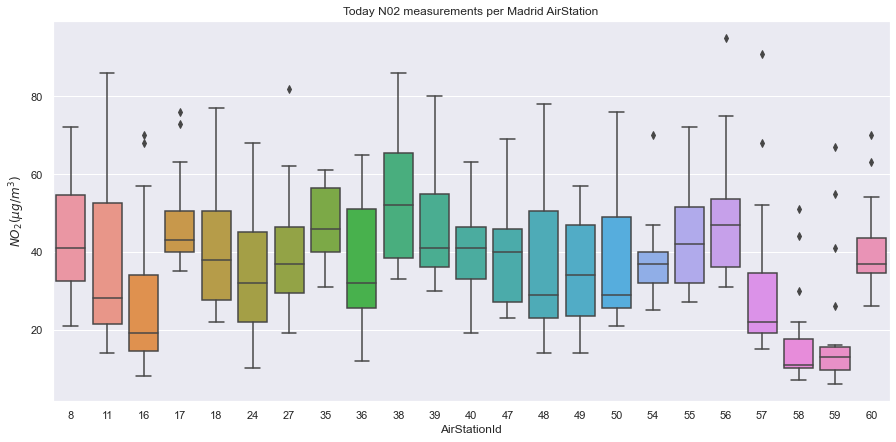

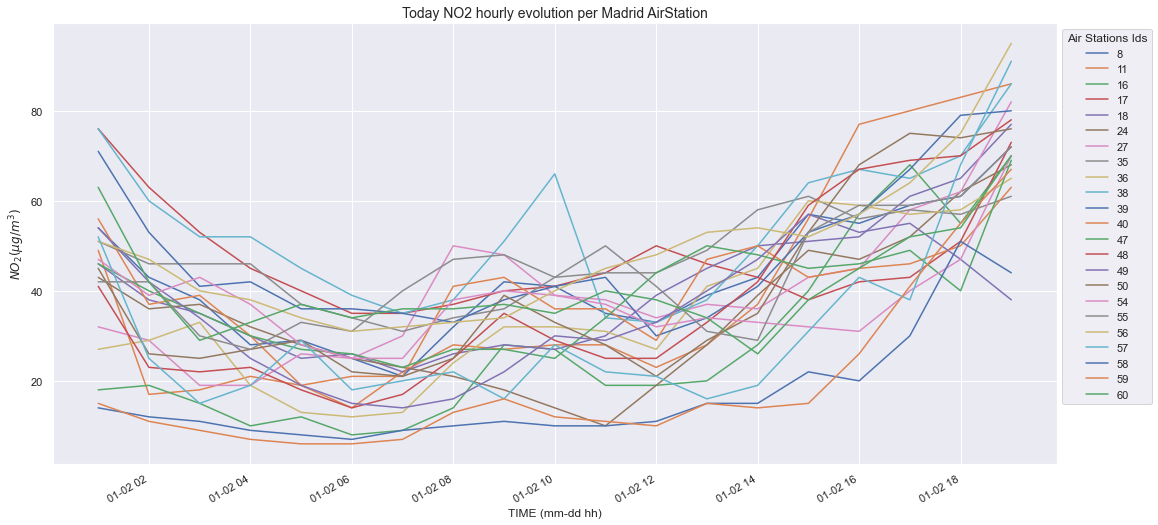

In [82]:
# N02 distribution per AirStation on live data
#############################################

sbn.set(rc={'figure.figsize':(15, 7)})
sbn.boxplot(data=df, x='AirStationId', y='NO2_index').set(title="Today N02 measurements per Madrid AirStation", ylabel='$NO_2 (µg/m^3)$');

#Plotting NO2 hourly evolution per AirStation
############################################
fig, ax = plt.subplots(figsize=(18,9))

df.groupby("AirStationId")['NO2_index'].plot(ax=ax);

plt.ylabel("$NO_2 (µg/m^3)$")
plt.xlabel("TIME (mm-dd hh)")
plt.title("Today NO2 hourly evolution per Madrid AirStation",fontsize=14);
plt.legend(title='Air Stations Ids',loc=2, bbox_to_anchor=(1,1));

# FOLIUM MAP TO VISUALIZE PREDICTION RESULTS

In [83]:
#Function to create prediction chart as a pop-up to be included in folium map
#############################################################################

def popup (df):
    if df is not None:
        df=df.loc[datetime.now().strftime("%Y-%m")] #cut dataframes to skip altair limitation of 5000 records to be plotted in the chart
        df.reset_index(inplace=True, drop=False) #removing index to allow correct altair time series plotting
        
        return alt.Chart(df).mark_line().encode(
        x=alt.X('index:T', axis=alt.Axis(title='TIME')),
        y=alt.Y('NO2_index:Q', axis=alt.Axis(title= "NO_2 (µg/m^3)")),
        color='Source:N').properties(height=200,
        width=300,title="Today NO2 evolution & 24hour prediction").interactive()

In [84]:
#Creation of charts per AirStations
###################################

chart4 = popup(df_4p)
chart8 = popup(df_8p)
chart11 = popup(df_11p)
chart16 = popup(df_16p)
chart17 = popup(df_17p)
chart18 = popup(df_18p)
chart24 = popup(df_24p)
chart27 = popup(df_27p)
chart35 = popup(df_35p)
chart36 = popup(df_36p)
chart38 = popup(df_38p)
chart39 = popup(df_39p)
chart40 = popup(df_40p)
chart47 = popup(df_47p)
chart48 = popup(df_48p)
chart49 = popup(df_49p)
chart50 = popup(df_50p)
chart54 = popup(df_54p)
chart55 = popup(df_55p)
chart56 = popup(df_56p)
chart57 = popup(df_57p)
chart58 = popup(df_58p)
chart59 = popup(df_59p)
chart60 = popup(df_60p)

In [85]:
#Folium framework
##################

map = folium.Map(width=850,height=750,location=[40.4398904,-3.6903729], zoom_start=11,min_zoom=8,max_zoom=18)


#Folium Airstations markers and pop-ups with measurements and predictions
#########################################################################

#AirStation4
if chart4 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart4, height=250, width=450).add_to(popup)
    folium.Marker([40.4238823,-3.7122567],
                     icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 4").add_to(map)

#AirStation8
if chart8 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart8, height=250, width=450).add_to(popup)
    folium.Marker([40.4215533,-3.6823158],
                     icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 8").add_to(map)

#AirStation11
if chart11 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart11, height=250, width=450).add_to(popup)
    folium.Marker([40.4514734,-3.6773491],
                     icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 11").add_to(map)

#AirStation16   
if chart16 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart16, height=250, width=450).add_to(popup)
    folium.Marker([40.4400457,-3.6392422],
                     icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 16").add_to(map)

#AirStation17  
if chart17 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart17, height=250, width=450).add_to(popup)
    folium.Marker([40.347147,-3.7133167],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 17").add_to(map)

#AirStation18
if chart18 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart18, height=250, width=450).add_to(popup)
    folium.Marker([40.3947825,-3.7318356],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 18").add_to(map)

#AirStation24  
if chart24 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart24, height=250, width=450).add_to(popup)
    folium.Marker([40.4193577,-3.7473445],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 24").add_to(map)

#AirStation27 
if chart27 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart27, height=250, width=450).add_to(popup)
    folium.Marker([40.4769179,-3.5800258],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 27").add_to(map)

#AirStation35    
if chart35 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart35, height=250, width=450).add_to(popup)
    folium.Marker([40.4192091,-3.7031662],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 35").add_to(map)

#AirStation36   
if chart36 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart36, height=250, width=450).add_to(popup)
    folium.Marker([40.4079517,-3.6453104],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 36").add_to(map)
#AirStation38  
if chart38 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart38, height=250, width=450).add_to(popup)
    folium.Marker([40.4455439,-3.7071303],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 38").add_to(map)
#AirStation39     
if chart39 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart39, height=250, width=450).add_to(popup)
    folium.Marker([40.4782322,-3.7115364],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 39").add_to(map)
#AirStation40 
if chart40 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart40, height=250, width=450).add_to(popup)
    folium.Marker([40.3881478,-3.6515286],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 40").add_to(map)
#AirStation47   
if chart47 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart47, height=250, width=450).add_to(popup)
    folium.Marker([40.3980991,-3.6868138],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 47").add_to(map)
#AirStation48  
if chart48 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart48, height=250, width=450).add_to(popup)
    folium.Marker([40.4398904,-3.6903729],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 48").add_to(map)
#AirStation49 
if chart49 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart49, height=250, width=450).add_to(popup)
    folium.Marker([40.4144444,-3.6824999],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 49").add_to(map)
#AirStation50  
if chart50 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart50, height=250, width=450).add_to(popup)
    folium.Marker([40.4655841,-3.6887449],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 50").add_to(map)
#AirStation54  
if chart54 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart54, height=250, width=450).add_to(popup)
    folium.Marker([40.3730118,-3.6121394],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 54").add_to(map)
#AirStation55  
if chart55 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart55, height=250, width=450).add_to(popup)
    folium.Marker([40.4623628,-3.5805649],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 55").add_to(map)
#AirStation56 
if chart56 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart56, height=250, width=450).add_to(popup)
    folium.Marker([40.3850336,-3.7187679],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 56").add_to(map)
#AirStation57    
if chart57 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart57, height=250, width=450).add_to(popup)
    folium.Marker([40.4942012,-3.6605173],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 57").add_to(map)
#AirStation58  
if chart58 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart58, height=250, width=450).add_to(popup)
    folium.Marker([40.5180701,-3.7746101],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 58").add_to(map)
#AirStation59   
if chart59 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart59, height=250, width=450).add_to(popup)
    folium.Marker([40.4607255,-3.6163407],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 59").add_to(map)
#AirStation60   
if chart60 is not None:
    popup = folium.Popup(max_width=650)
    folium.features.VegaLite(chart60, height=250, width=450).add_to(popup)
    folium.Marker([40.5005477,-3.6897308],
                 icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),popup=popup,tooltip="Station 60").add_to(map)


map.save("../reports/MadridMap_basic.html")
map


Map with the AirStation locations in Madrid. Clicking over everyone a popup chart is displayed showing the today measurements available (real time data), together 24hour prediction

In [86]:
#Folium framework2
##################

map = folium.Map(width=850,height=750,location=[40.4398904,-3.6903729], zoom_start=11,min_zoom=8,max_zoom=18)


#Folium Airstations markers and pop-ups with measurements and predictions
#########################################################################

#AirStation4 
if not df[df['AirStationId']==4][-1:].empty:
    lastdata=df[df['AirStationId']==4][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart4, height=250, width=450).add_to(popup)
        folium.Marker([40.4238823,-3.7122567],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 4 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart4, height=250, width=450).add_to(popup)
        folium.Marker([40.4238823,-3.7122567],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 4  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart4, height=250, width=450).add_to(popup)
        folium.Marker([40.4238823,-3.7122567],
                    icon=folium.Icon(color="gray", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 4 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
              
    

#AirStation8 
if not df[df['AirStationId']==8][-1:].empty:
    lastdata=df[df['AirStationId']==8][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart8, height=250, width=450).add_to(popup)
        folium.Marker([40.4215533,-3.6823158],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 8 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart8, height=250, width=450).add_to(popup)
        folium.Marker([40.4215533,-3.6823158],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 8  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart8, height=250, width=450).add_to(popup)
        folium.Marker([40.4215533,-3.6823158],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 8 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
              
#AirStation11  
if not df[df['AirStationId']==11][-1:].empty:
    lastdata=df[df['AirStationId']==11][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart11, height=250, width=450).add_to(popup)
        folium.Marker([40.4514734,-3.6773491],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 11 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart11, height=250, width=450).add_to(popup)
        folium.Marker([40.4514734,-3.6773491],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 11  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart11, height=250, width=450).add_to(popup)
        folium.Marker([40.4514734,-3.6773491],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 11 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
              

#AirStation16  
if not df[df['AirStationId']==16][-1:].empty:
    lastdata=df[df['AirStationId']==16][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart16, height=250, width=450).add_to(popup)
        folium.Marker([40.4400457,-3.6392422],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 16 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart16, height=250, width=450).add_to(popup)
        folium.Marker([40.4400457,-3.6392422],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 16  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart16, height=250, width=450).add_to(popup)
        folium.Marker([40.4400457,-3.6392422],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 16 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
              

#AirStation17  
if not df[df['AirStationId']==17][-1:].empty:
    lastdata=df[df['AirStationId']==17][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart17, height=250, width=450).add_to(popup)
        folium.Marker([40.347147,-3.7133167],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 17 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart17, height=250, width=450).add_to(popup)
        folium.Marker([40.347147,-3.7133167],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 17  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart17, height=250, width=450).add_to(popup)
        folium.Marker([40.347147,-3.7133167],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 17 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               

#AirStation18  
if not df[df['AirStationId']==18][-1:].empty:
    lastdata=df[df['AirStationId']==18][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart18, height=250, width=450).add_to(popup)
        folium.Marker([40.3947825,-3.7318356],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 18 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart18, height=250, width=450).add_to(popup)
        folium.Marker([40.3947825,-3.7318356],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 18  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart18, height=250, width=450).add_to(popup)
        folium.Marker([40.3947825,-3.7318356],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 18 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
    

#AirStation24  
if not df[df['AirStationId']==24][-1:].empty:
    lastdata=df[df['AirStationId']==24][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart24, height=250, width=450).add_to(popup)
        folium.Marker([40.4193577,-3.7473445],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 24 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart24, height=250, width=450).add_to(popup)
        folium.Marker([40.4193577,-3.7473445],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 24  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart24, height=250, width=450).add_to(popup)
        folium.Marker([40.4193577,-3.7473445],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 24 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
    
#AirStation27  
if not df[df['AirStationId']==27][-1:].empty:
    lastdata=df[df['AirStationId']==27][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart27, height=250, width=450).add_to(popup)
        folium.Marker([40.4769179,-3.5800258],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 27 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart27, height=250, width=450).add_to(popup)
        folium.Marker([40.4769179,-3.5800258],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 27  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart27, height=250, width=450).add_to(popup)
        folium.Marker([40.4769179,-3.5800258],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 27 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation35  
if not df[df['AirStationId']==35][-1:].empty:
    lastdata=df[df['AirStationId']==35][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart35, height=250, width=450).add_to(popup)
        folium.Marker([40.4192091,-3.7031662],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 35 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart35, height=250, width=450).add_to(popup)
        folium.Marker([40.4192091,-3.7031662],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 35  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart35, height=250, width=450).add_to(popup)
        folium.Marker([40.4192091,-3.7031662],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 35 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
    
#AirStation36  
if not df[df['AirStationId']==36][-1:].empty:
    lastdata=df[df['AirStationId']==36][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart36, height=250, width=450).add_to(popup)
        folium.Marker([40.4079517,-3.6453104],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 36 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart36, height=250, width=450).add_to(popup)
        folium.Marker([40.4079517,-3.6453104],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 36  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart36, height=250, width=450).add_to(popup)
        folium.Marker([40.4079517,-3.6453104],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 36 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
    
#AirStation38  
if not df[df['AirStationId']==38][-1:].empty:
    lastdata=df[df['AirStationId']==38][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart38, height=250, width=450).add_to(popup)
        folium.Marker([40.4455439,-3.7071303],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 38 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart38, height=250, width=450).add_to(popup)
        folium.Marker([40.4455439,-3.7071303],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 38  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart38, height=250, width=450).add_to(popup)
        folium.Marker([40.4455439,-3.7071303],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 38 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation39  
if not df[df['AirStationId']==39][-1:].empty:
    lastdata=df[df['AirStationId']==39][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart39, height=250, width=450).add_to(popup)
        folium.Marker([40.4782322,-3.7115364],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 39 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart39, height=250, width=450).add_to(popup)
        folium.Marker([40.4782322,-3.7115364],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 39  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart39, height=250, width=450).add_to(popup)
        folium.Marker([40.4782322,-3.7115364],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 39 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation40  
if not df[df['AirStationId']==40][-1:].empty:
    lastdata=df[df['AirStationId']==40][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart40, height=250, width=450).add_to(popup)
        folium.Marker([40.3881478,-3.6515286],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 40 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart40, height=250, width=450).add_to(popup)
        folium.Marker([40.3881478,-3.6515286],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 40  / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart40, height=250, width=450).add_to(popup)
        folium.Marker([40.3881478,-3.6515286],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 40 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation47  
if not df[df['AirStationId']==47][-1:].empty:
    lastdata=df[df['AirStationId']==47][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart47, height=250, width=450).add_to(popup)
        folium.Marker([40.3980991,-3.6868138],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 47 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart47, height=250, width=450).add_to(popup)
        folium.Marker([40.3980991,-3.6868138],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 47 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart47, height=250, width=450).add_to(popup)
        folium.Marker([40.3980991,-3.6868138],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 47 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation48  
if chart48 is not None:
    lastdata=df[df['AirStationId']==48][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart48, height=250, width=450).add_to(popup)
        folium.Marker([40.4398904,-3.6903729],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 48 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart48, height=250, width=450).add_to(popup)
        folium.Marker([40.4398904,-3.6903729],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 48 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart48, height=250, width=450).add_to(popup)
        folium.Marker([40.4398904,-3.6903729],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 48 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation49  
if not df[df['AirStationId']==49][-1:].empty:
    lastdata=df[df['AirStationId']==49][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart49, height=250, width=450).add_to(popup)
        folium.Marker([40.4144444,-3.6824999],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 49 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart49, height=250, width=450).add_to(popup)
        folium.Marker([40.4144444,-3.6824999],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 49 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart49, height=250, width=450).add_to(popup)
        folium.Marker([40.4144444,-3.6824999],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 49 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation50  
if not df[df['AirStationId']==50][-1:].empty:
    lastdata=df[df['AirStationId']==50][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart50, height=250, width=450).add_to(popup)
        folium.Marker([40.4655841,-3.6887449],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 50 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart50, height=250, width=450).add_to(popup)
        folium.Marker([40.4655841,-3.6887449],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 50 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart50, height=250, width=450).add_to(popup)
        folium.Marker([40.4655841,-3.6887449],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 50 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation54  
if not df[df['AirStationId']==54][-1:].empty:
    lastdata=df[df['AirStationId']==54][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart54, height=250, width=450).add_to(popup)
        folium.Marker([40.3730118,-3.6121394],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 54 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart54, height=250, width=450).add_to(popup)
        folium.Marker([40.3730118,-3.6121394],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 54 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart54, height=250, width=450).add_to(popup)
        folium.Marker([40.3730118,-3.6121394],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 54 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
               
#AirStation55  
if not df[df['AirStationId']==55][-1:].empty:
    lastdata=df[df['AirStationId']==55][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart55, height=250, width=450).add_to(popup)
        folium.Marker([40.4623628,-3.5805649],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 55 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart55, height=250, width=450).add_to(popup)
        folium.Marker([40.4623628,-3.5805649],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 55 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart55, height=250, width=450).add_to(popup)
        folium.Marker([40.4623628,-3.5805649],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 55 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

#AirStation56  
if not df[df['AirStationId']==56][-1:].empty:
    lastdata=df[df['AirStationId']==56][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart56, height=250, width=450).add_to(popup)
        folium.Marker([40.3850336,-3.7187679],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 56 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart56, height=250, width=450).add_to(popup)
        folium.Marker([40.3850336,-3.7187679],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 56 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart56, height=250, width=450).add_to(popup)
        folium.Marker([40.3850336,-3.7187679],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 56 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

#AirStation57  
if not df[df['AirStationId']==57][-1:].empty:
    lastdata=df[df['AirStationId']==57][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart57, height=250, width=450).add_to(popup)
        folium.Marker([40.4942012,-3.6605173],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 57 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart57, height=250, width=450).add_to(popup)
        folium.Marker([40.4942012,-3.6605173],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 57 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart57, height=250, width=450).add_to(popup)
        folium.Marker([40.4942012,-3.6605173],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 57 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)



#AirStation58  
if not df[df['AirStationId']==58][-1:].empty:
    lastdata=df[df['AirStationId']==58][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart58, height=250, width=450).add_to(popup)
        folium.Marker([40.5180701,-3.7746101],
                icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                popup=popup,tooltip="AirStation: 58 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)
        
    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart58, height=250, width=450).add_to(popup)
        folium.Marker([40.5180701,-3.7746101],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 58 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart58, height=250, width=450).add_to(popup)
        folium.Marker([40.5180701,-3.7746101],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 58 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

        
#AirStation59   
if not df[df['AirStationId']==59][-1:].empty:
    lastdata=df[df['AirStationId']==59][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart59, height=250, width=450).add_to(popup)
        folium.Marker([40.4607255,-3.6163407],
                    icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 59 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart59, height=250, width=450).add_to(popup)
        folium.Marker([40.4607255,-3.6163407],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 59 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart59, height=250, width=450).add_to(popup)
        folium.Marker([40.4607255,-3.6163407],
                    icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 59 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

#AirStation60   
if not df[df['AirStationId']==60][-1:].empty:
    lastdata=df[df['AirStationId']==60][-1:]
    if lastdata.iloc[0]['NO2_index'] >50 and lastdata.iloc[0]['NO2_index']<200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart60, height=250, width=450).add_to(popup)
        folium.Marker([40.5005477,-3.6897308],
                    icon=folium.Icon(color="orange", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 60 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    elif lastdata.iloc[0]['NO2_index'] >200:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart60, height=250, width=450).add_to(popup)
        folium.Marker([40.5005477,-3.6897308],
                    icon=folium.Icon(color="red", icon='cloud',prefix='fa'),
                    popup=popup,tooltip="AirStation: 60 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

    else:
        popup = folium.Popup(max_width=650)
        folium.features.VegaLite(chart60, height=250, width=450).add_to(popup)
        folium.Marker([40.5005477,-3.6897308],
                     icon=folium.Icon(color="green", icon='cloud',prefix='fa'),
                     popup=popup,tooltip="AirStation: 60 / Current NO2: "+str(lastdata.iloc[0]['NO2_index'])).add_to(map)

map.save("../reports/MadridMap.html")
map
